In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import zarr
from skimage import data
from skimage import filters
import gunpowder as gp
import os
import numpy as np
import tifffile as tiff


#%%
from funlib.learn.torch.models import UNet, ConvPass
import logging
import math
import torch
import multiprocessing
# multiprocessing.set_start_method("fork")
import gunpowder as gp
import zarr
# from iohub import open_ome_zarr
import matplotlib.pyplot as plt
import math

In [17]:
#%%
store_path = '/mnt/efs/shared_data/hack/data/20230811/20230811_raw.zarr/fov0'

# img_list = os.listdir(img_path)
#gt_string = '_deconvolved_rho_0.0038_gamma_0.013_m2_Manual_Mask.tiff'

f = zarr.open(store_path, 'r')
#%%
f['raw'].shape

(64, 640, 640)

In [30]:

# helper function to show image(s), channels first
def imshow(raw, slice_index=0, ground_truth=None, prediction=None):
    num_images = 1
    rows = 1
    if ground_truth is not None:
        rows += 1
    if prediction is not None:
        rows += 1
    cols = num_images

    fig, axes = plt.subplots(rows, cols, figsize=(20, 8), sharex=True, sharey=True, squeeze=False)

    # Select and display the specified slice from the 'raw' data
    selected_slice = raw[slice_index, :, :]
    axes[0][0].imshow(selected_slice, cmap='gray')  # Assuming grayscale images

    plt.show()


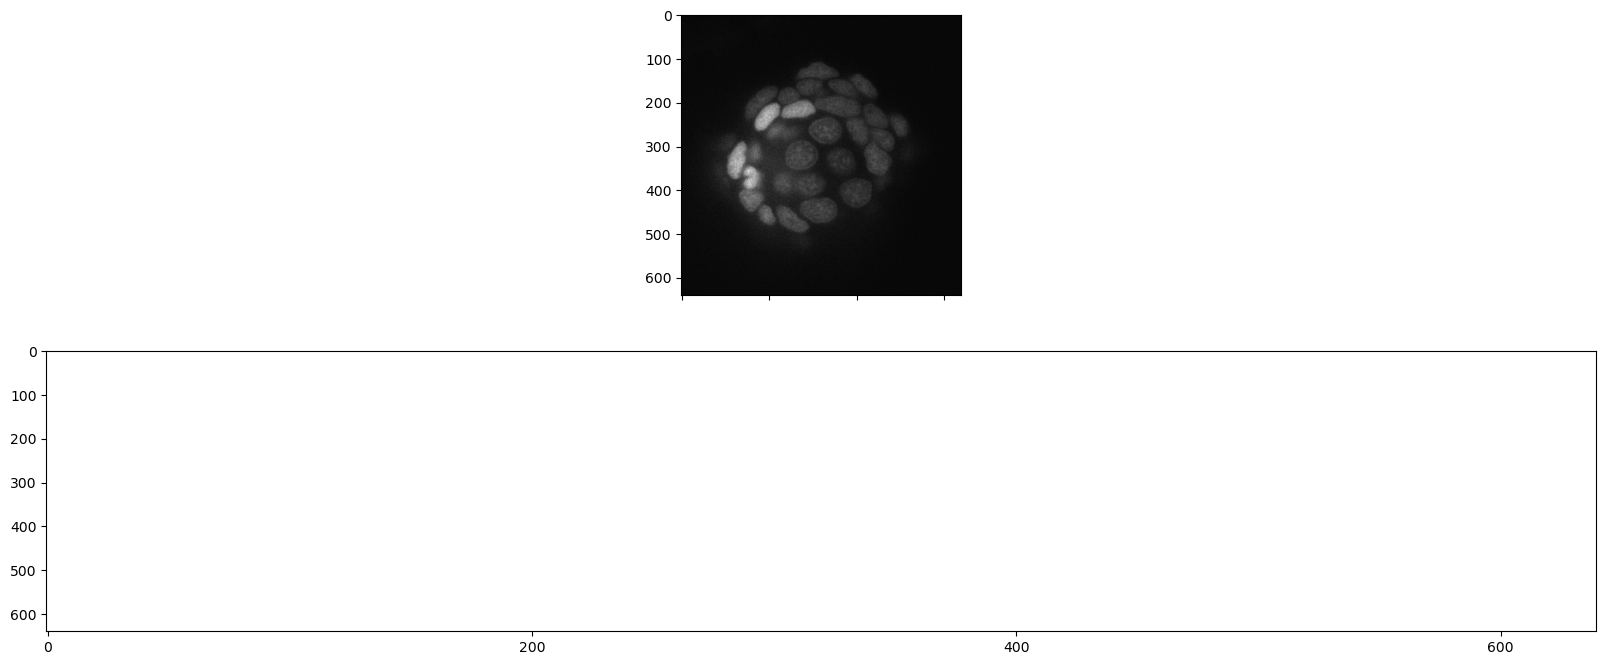

In [42]:
imshow(f['raw'], ground_truth= f['gt'], slice_index = 20)

In [35]:
# Make an array key for the raw data and the ground truth
raw = gp.ArrayKey('RAW')
gt = gp.ArrayKey('GROUND_TRUTH')

In [36]:
# Enable random location sampling 
random_location = gp.RandomLocation()

In [37]:
simple_augment = gp.SimpleAugment()

In [38]:
# stack = gp.Stack(5)

In [39]:
elastic_augment = gp.ElasticAugment(
  control_point_spacing=(20, 20),
  jitter_sigma=(1.0, 1.0),
  rotation_interval=(0, math.pi/2))

In [41]:
# Make this 'pipeline' thingy
source = gp.ZarrSource(
    store_path,
    {
      raw: 'raw',
     # gt: 'gt'
    },
    {
      raw: gp.ArraySpec(interpolatable=True,
        voxel_size=(1,1)),
     # gt: gp.ArraySpec(interpolatable=False)
    })

pipeline = source + random_location + simple_augment + elastic_augment

# formulate a request for "raw"
request = gp.BatchRequest()
request[raw] = gp.Roi((0,0), (256, 256))
#request[gt] = gp.Roi((0,0), (256, 256))

# build the pipeline...
with gp.build(pipeline):

    # ...and request a batch
    batch = pipeline.request_batch(request)

# show the content of the batch
print(f"batch returned: {batch}")
imshow(batch[raw].data)

PipelineRequestError: Exception in pipeline:
ZarrSource[/mnt/efs/shared_data/hack/data/20230811/20230811_raw.zarr/fov0] -> RandomLocation -> SimpleAugment -> ElasticAugment
while trying to process request

	RAW: ROI: [0:256, 0:256] (256, 256), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False


batch returned: 
	RAW: ROI: [200:264, 260:324] (64, 64), voxel size: (1, 1), interpolatable: True, non-spatial: False, dtype: uint16, placeholder: False



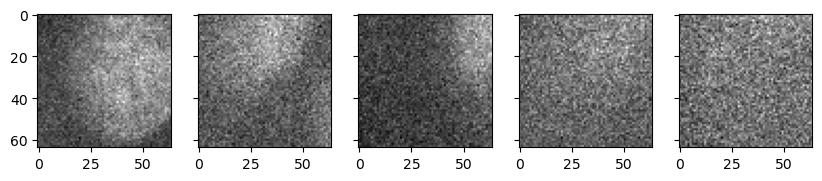

In [ ]:
### Intensity augmentations ###
normalize = gp.Normalize(raw)
intensity_augment = gp.IntensityAugment(
  raw,
  scale_min=0.8,
  scale_max=1.2,
  shift_min=-0.2,
  shift_max=0.2)
noise_augment = gp.NoiseAugment(raw)

In [ ]:
### Elastic augmentations ###
elastic_augment = gp.ElasticAugment(
  control_point_spacing=(16, 16),
  jitter_sigma=(4.0, 4.0),
  rotation_interval=(0, math.pi/2))

In [2]:
stack = gp.Stack(5)

In [ ]:
gt = gp.ArrayKey('GROUND_TRUTH')

source = gp.ZarrSource(
    'sample_data.zarr',
    {
      raw: 'raw',
      gt: 'ground_truth'
    },
    {
      raw: gp.ArraySpec(interpolatable=True),
      gt: gp.ArraySpec(interpolatable=False)
    })

request[gt] = gp.Roi((0, 0), (64, 128))

pipeline = (
  source +
  normalize +
  random_location +
  simple_augment +
  elastic_augment +
  intensity_augment +
  noise_augment +
  stack)

with gp.build(pipeline):
  batch = pipeline.request_batch(request)

imshow(batch[raw].data, batch[gt].data)

In [ ]:
with open_ome_zarr(
    store_path ,
    mode="r",
    layout="auto",
) as dataset:
    dataset.print_tree()  # prints the hierarchy of the zarr store
    channel_names = dataset.channel_names
    print(channel_names)
    # img_array = dataset[
    #     "B/03/0/0"
    # # ]  # lazy Zarr array for the raw image in the first position
    # raw_data = img_array.numpy()  # loads a CZYX 4D array into RAM
    # print(raw_data.mean())  # does some analysis

# with open_ome_zarr(
#     "max_intensity_projection.zarr",
#     mode="w-",
#     layout="hcs",
#     channel_names=channel_names,
# ) as dataset:
#     new_fov = dataset.create_position(
#         "B", "03", "0"
#     )  # creates fov with the same path
#     new_fov["0"] = raw_data.max(axis=1).reshape(
#         (1, 1, 1, *raw_data.shape[2:])
#     )  # max projection along Z axis and prepend dims to 5D
#     dataset.print_tree()  # checks that new data has been written
